# Final Project. Communities and Crime

The objective of this project is to predict the _ViolentCrimesPerPop_ quantity which ilustrates the number of violent crimes per 100k population.

## Import all necessary packages

In [49]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv

from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

## Exploring and Cleaning Data

### Extract columns names from _communities.names_

In [50]:
with open("communities.names") as NamesFile:
    Lines = NamesFile.readlines()[75:203]
ColumnsNames = [Line.split()[1] for Line in Lines]

### Read data from _communities.data_

In [51]:
Data = pd.read_csv("communities.data", index_col=False, names=ColumnsNames)
# Check if DataFrame looks ok...
Data.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


For easier data manipulation, we will make a copy of the whole DataFrame without the _communityname_ column.

In [52]:
Data = Data.drop(["communityname"], axis=1)
Data

,state,county,community,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,1,0.19,0.33,0.02,0.90,0.12,0.17,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,1,0.00,0.16,0.12,0.74,0.45,0.07,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,1,0.00,0.42,0.49,0.56,0.17,0.04,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,1,0.04,0.77,1.00,0.08,0.12,0.10,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,1,0.01,0.55,0.02,0.95,0.09,0.05,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,10,0.01,0.40,0.10,0.87,0.12,0.16,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,10,0.05,0.96,0.46,0.28,0.83,0.32,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,10,0.16,0.37,0.25,0.69,0.04,0.25,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,10,0.08,0.51,0.06,0.87,0.22,0.10,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [53]:
# General info about the data
Data.info()
# Getting number of communities
n_communities = len(Data)
print(f"\nTotal of communities: {n_communities}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 127 entries, state to ViolentCrimesPerPop
dtypes: float64(100), int64(2), object(25)
memory usage: 1.9+ MB

Total of communities: 1994


### Dropping columns with deficient total data
Some columns might have half or more of the total data as non-defined, all these written as a "?", so we will drop the columns that might not help us for the analysis.

In [54]:
with open("DeficientColumnsData.csv", "w") as DefData:
    HalfNumCommunities = n_communities//2
    for ColumnName in Data.columns:
        # Get number of "?" in given column and check if it is more or equal than the
        # total of communties
        Total_UnknownDataColumn = (Data[ColumnName] == "?").sum()
        if Total_UnknownDataColumn >= HalfNumCommunities:

            DefData.write(f"{ColumnName},{Total_UnknownDataColumn}\n")
            Data.drop(labels=[ColumnName], axis=1, inplace=True)

print(Data.info())
Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 103 entries, state to ViolentCrimesPerPop
dtypes: float64(100), int64(2), object(1)
memory usage: 1.6+ MB
None


,state,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,8,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,53,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,24,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,34,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,42,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,10,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,6,10,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,9,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,25,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


### Exploring isolated non-defined data
Now we will check if there is still columns with strings or non-numerical data in them.

In [55]:
Data.dtypes[Data.dtypes != "int64"][Data.dtypes != "float64"]

OtherPerCap    object
dtype: object

We can see that _OtherPerCap_ column has object dtype so let's observe the head column.

In [56]:
Data.OtherPerCap.head()

0    0.36
1    0.22
2    0.28
3    0.36
4    0.51
Name: OtherPerCap, dtype: object

It seems we have numerical data so let's search for any non-numerical data in it.

In [57]:
def CheckFloat(x):
    try:
        y = float(x)
        return True
    except ValueError:
        return False
    
Rows_NonNum_OtherPerCap = list( Data.OtherPerCap.index[Data.OtherPerCap.apply(CheckFloat) == False])
Data.loc[Rows_NonNum_OtherPerCap, "OtherPerCap"]

130    ?
Name: OtherPerCap, dtype: object

There is only data with a non-numeric value, so we decided to replace it with the mean value.

In [58]:
# Replacing OtherPerPop in index 130 with the mean of the available data
def GetMean_PrevOtherPerPop(Data):
    Sum = 0.0
    Values = Data.OtherPerCap.values
    for Val in Values:
        try:
            Sum += float(Val)
        except ValueError:
            pass
    return Sum/len(Values)

Data.loc[Rows_NonNum_OtherPerCap, "OtherPerCap"] = GetMean_PrevOtherPerPop(Data)
Data = Data.astype({"OtherPerCap":"float64"})
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 103 entries, state to ViolentCrimesPerPop
dtypes: float64(101), int64(2)
memory usage: 1.6 MB


And the final step for cleaning the dataset is dropping categorical data that won't contribute to the analysis as _state_ and _fold_ variables

In [59]:
Data.drop(["state", "fold"], axis=1, inplace=True)

## Transforming dataset to logaritmic scale

As final step, let's generate a DataFrame into logaritmic scale of the form
$$ \text{Log-Data} = \log{(1 + \text{Data} - \text{min(Data))}}$$

In [60]:
LogData = dict()
for n, column in enumerate(Data.columns):
    LogData[column] = np.log10( 1.0  + Data[column] - Data[column].min())
 
Data = pd.DataFrame(LogData)

print(Data.info())
Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 101 entries, population to ViolentCrimesPerPop
dtypes: float64(101)
memory usage: 1.5 MB
None


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.075547,0.123852,0.008600,0.278754,0.049218,0.068186,0.127105,0.167317,0.110590,0.120574,...,0.049218,0.152288,0.176091,0.178977,0.214844,0.049218,0.100371,0.079181,0.120574,0.079181
1,0.000000,0.064458,0.049218,0.240549,0.161368,0.029384,0.100371,0.201397,0.130334,0.103804,...,0.082785,0.176091,0.127105,0.204120,0.181844,0.008600,0.049218,0.161368,0.000000,0.222716
2,0.000000,0.152288,0.173186,0.193125,0.068186,0.017033,0.143015,0.167317,0.107210,0.120574,...,0.056905,0.173186,0.187521,0.222716,0.193125,0.004321,0.082785,0.008600,0.000000,0.155336
3,0.017033,0.247973,0.301030,0.033424,0.049218,0.041393,0.178977,0.176091,0.127105,0.082785,...,0.075547,0.113943,0.238046,0.214844,0.217484,0.008600,0.143015,0.107210,0.000000,0.049218
4,0.004321,0.190332,0.008600,0.290035,0.037426,0.021189,0.139879,0.139879,0.089905,0.133539,...,0.045323,0.235528,0.214844,0.206826,0.184691,0.017033,0.037426,0.008600,0.000000,0.012837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.004321,0.146128,0.041393,0.271842,0.049218,0.064458,0.155336,0.178977,0.130334,0.113943,...,0.086360,0.107210,0.127105,0.170262,0.143015,0.004321,0.107210,0.021189,0.000000,0.037426
1990,0.021189,0.292256,0.164353,0.107210,0.262451,0.120574,0.227887,0.269513,0.238046,0.056905,...,0.184691,0.096910,0.068186,0.041393,0.000000,0.008600,0.136721,0.079181,0.000000,0.161368
1991,0.064458,0.136721,0.096910,0.227887,0.017033,0.096910,0.130334,0.176091,0.117271,0.187521,...,0.096910,0.225309,0.206826,0.252853,0.245513,0.033424,0.120574,0.071882,0.281033,0.089905
1992,0.033424,0.178977,0.025306,0.271842,0.086360,0.041393,0.198657,0.240549,0.212188,0.149219,...,0.161368,0.214844,0.187521,0.201397,0.181844,0.012837,0.139879,0.123852,0.086360,0.075547


## Exploratory Data Analysis

### Correlation matrix of all columns

<AxesSubplot: >

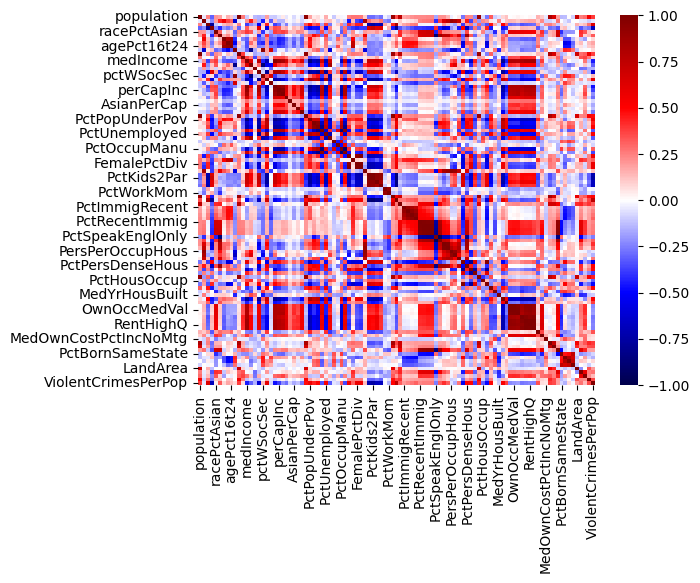

In [61]:
CorrMap = Data.corr()

sns.heatmap(CorrMap, vmin=-1, vmax=1, cmap="seismic", annot=False)

## Principal Components Analysis
The objective of applying this methodology is to identify and visualize the weights of multiple n-components of our dataset and catch the variables, or columns, with more relevance

In [62]:
N_variables = len(Data.columns)
PCA_Data = PCA(n_components=N_variables)
PCA_Data.fit(Data)

PCA(n_components=101)

In [63]:
PCA_Data.explained_variance_ratio_

array([2.72197415e-01, 1.94815904e-01, 7.88562866e-02, 6.83348714e-02,
       4.57245430e-02, 3.70141482e-02, 3.12302668e-02, 2.69996112e-02,
       2.09385501e-02, 1.88726154e-02, 1.35712457e-02, 1.31685891e-02,
       1.21155975e-02, 1.17824101e-02, 1.02231959e-02, 8.79924305e-03,
       8.46645485e-03, 7.56271622e-03, 6.96736136e-03, 6.75506379e-03,
       6.40291681e-03, 6.17111921e-03, 5.62693899e-03, 5.39819223e-03,
       4.74217682e-03, 4.34599568e-03, 4.30643394e-03, 3.90600938e-03,
       3.73230527e-03, 3.64474411e-03, 3.52557302e-03, 3.25425362e-03,
       3.20442178e-03, 3.14003271e-03, 2.69264875e-03, 2.62300579e-03,
       2.49587055e-03, 2.28760897e-03, 2.15197696e-03, 2.04994154e-03,
       1.92220566e-03, 1.81805010e-03, 1.68765738e-03, 1.55380406e-03,
       1.46566476e-03, 1.38654637e-03, 1.23725032e-03, 1.08462690e-03,
       1.03259991e-03, 1.01908053e-03, 9.01865715e-04, 8.73893356e-04,
       8.26528723e-04, 7.83753543e-04, 7.58316934e-04, 7.14043417e-04,
      

<BarContainer object of 101 artists>

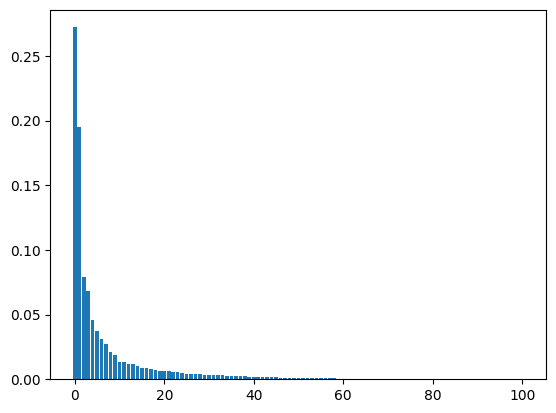

In [64]:
plt.bar(range(N_variables), PCA_Data.explained_variance_ratio_)

Then, let's save the rounded values with 4 decimals of the estimated weights for each variable in every eigenvector produced by PCA

In [65]:
AbsCompsPCA = np.abs(PCA_Data.components_)
IndexMaxVals_Vectors = np.argmax(AbsCompsPCA, axis=0)

And for more insight of these components, let's calculate how many of these we need to considere to represent the 85%, 90% and 95% of the total variance of the dataset.

In [66]:
def Find_NumCompsByPercent(Percent):
    if isinstance(Percent, float):
        N = 1
        while True:
            SumVar = PCA_Data.explained_variance_ratio_[:N].sum()
            
            if SumVar >= Percent:
                return (N, SumVar)
            else:
                N += 1

In [67]:
Percents = [0.85, 0.90, 0.95]
Num_SumVar = Find_NumCompsByPercent(Percents)

We got that with the first 15, 22 and 33 components we have an 85%, 90% and 95% of the variance respectively. So then, we will select only the maximum absolute weights of the first 15 or less non-repeated components.

In [68]:
Prior_VarComponents = set(IndexMaxVals_Vectors[:22])
Prior_VarComponents, len(Prior_VarComponents)

({4, 23, 35, 37, 44, 48, 53, 59, 73, 77, 78, 81, 84, 91, 94, 98}, 16)

Now let's generate a _FinalData_ DataFrame with these columns indexes

In [69]:
FinalData = dict()
for index, column in enumerate(Data.columns):
    if index in Prior_VarComponents:
        FinalData[column] = Data.loc[:, column].to_numpy()

FinalData = pd.DataFrame(FinalData)
FinalData["ViolentCrimesPerPop"] = Data.ViolentCrimesPerPop

print(FinalData.info())
FinalData

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   racePctAsian         1994 non-null   float64
 1   indianPerCap         1994 non-null   float64
 2   PctEmplProfServ      1994 non-null   float64
 3   PctOccupMgmtProf     1994 non-null   float64
 4   PctKids2Par          1994 non-null   float64
 5   PctWorkMom           1994 non-null   float64
 6   PctImmigRec5         1994 non-null   float64
 7   PctRecImmig10        1994 non-null   float64
 8   PctHousOwnOcc        1994 non-null   float64
 9   PctHousNoPhone       1994 non-null   float64
 10  PctWOFullPlumb       1994 non-null   float64
 11  OwnOccHiQuart        1994 non-null   float64
 12  RentHighQ            1994 non-null   float64
 13  PctForeignBorn       1994 non-null   float64
 14  PctSameCity85        1994 non-null   float64
 15  PctUsePubTrans       1994 non-null   f

,racePctAsian,indianPerCap,PctEmplProfServ,PctOccupMgmtProf,PctKids2Par,PctWorkMom,PctImmigRec5,PctRecImmig10,PctHousOwnOcc,PctHousNoPhone,PctWOFullPlumb,OwnOccHiQuart,RentHighQ,PctForeignBorn,PctSameCity85,PctUsePubTrans,ViolentCrimesPerPop
0,0.049218,0.103804,0.149219,0.181844,0.201397,0.245513,0.103804,0.033424,0.181844,0.056905,0.025306,0.071882,0.139879,0.049218,0.178977,0.079181,0.079181
1,0.161368,0.064458,0.060698,0.133539,0.167317,0.184691,0.209515,0.089905,0.093422,0.064458,0.000000,0.082785,0.146128,0.082785,0.204120,0.161368,0.222716
2,0.068186,0.029384,0.110590,0.120574,0.158362,0.222716,0.025306,0.021189,0.149219,0.167317,0.161368,0.064458,0.103804,0.056905,0.222716,0.008600,0.155336
3,0.049218,0.064458,0.161368,0.143015,0.187521,0.269513,0.079181,0.045323,0.292256,0.045323,0.045323,0.075547,0.247973,0.075547,0.214844,0.107210,0.049218
4,0.037426,0.000000,0.139879,0.164353,0.281033,0.204120,0.029384,0.021189,0.271842,0.021189,0.056905,0.113943,0.139879,0.045323,0.206826,0.008600,0.012837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.049218,0.000000,0.225309,0.230449,0.225309,0.238046,0.149219,0.071882,0.190332,0.029384,0.037426,0.103804,0.149219,0.086360,0.170262,0.021189,0.037426
1990,0.262451,0.071882,0.149219,0.093422,0.212188,0.146128,0.209515,0.206826,0.086360,0.068186,0.136721,0.133539,0.206826,0.184691,0.041393,0.079181,0.161368
1991,0.017033,0.075547,0.146128,0.120574,0.152288,0.164353,0.068186,0.049218,0.136721,0.117271,0.110590,0.110590,0.143015,0.096910,0.252853,0.071882,0.089905
1992,0.086360,0.079181,0.195900,0.170262,0.217484,0.212188,0.164353,0.139879,0.123852,0.041393,0.127105,0.167317,0.243038,0.161368,0.201397,0.123852,0.075547


## Searching of outliers in data
For the final DataFrame, we will drop the _state_ and _fold_ columns since they are categorical data and drop outliers by using the Mahalanobis distance of the form:
$$D = \sqrt{(X-\mu)^{'}S^{-1}(X-\mu)}$$

Where $X$ are the data points, $\mu$ es the mean vector and $S$ is the covariance matrix of the whole dataset

In [70]:
# Getting mean vector and covariance matrix
MeanVec = FinalData.mean(axis=0)
InvCovMatrix = inv(FinalData.cov(ddof=0).to_numpy())

# Computing Mahalanobis distance
NumRows = len(FinalData.index)
DataColumns = FinalData.columns

MahaDistance = np.zeros(NumRows)
for row in range(NumRows):
    MahaDistance[row] = mahalanobis(FinalData.loc[row, DataColumns].to_numpy(), MeanVec, InvCovMatrix)

MahaDistance, MahaDistance.min(), MahaDistance.max()

(array([2.31942926, 5.2916033 , 3.59937003, ..., 2.89410294, 3.21575726,
        4.20472412]),
 1.4345160194317417,
 8.85023357656214)

In [71]:
FinalData.to_csv("Log_FinalData.csv")

## Exploratory Data Analysis

<AxesSubplot: >

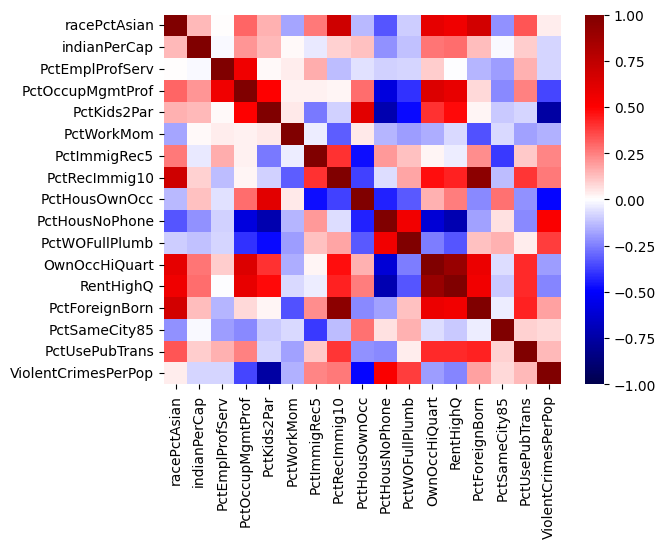

In [72]:
CorrMap = FinalData.corr()

sns.heatmap(CorrMap, vmin=-1, vmax=1, cmap="seismic", annot=False)